***IMPORTING LIBRARIES***

In [ ]:
# Importing Data Analysis Libraries
import pandas as pd
import numpy as np

# Normalize Dataset
from sklearn.preprocessing import MinMaxScaler

# Splitting Data into train set and Test set
from sklearn.model_selection import train_test_split

# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("darkgrid")

# Python drawing
from IPython.core.pylabtools import figsize

# Importing Tensorflow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger # Generating Model logs
from tensorflow.keras.utils import plot_model


# Model Evaluation
from sklearn.metrics import r2_score

# Convert Object to Datetime and display in matplotlib without casting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# TF Global random seed set for reproducibility
tf.random.set_seed(29)

***DEFINING GLOBAL VARIABLES AND FUNCTIONS FOR CODE REUSE***

In [ ]:
# Creating directory for saving log and model.
!mkdir -p saved_data

# CSVLogger variable for generating model logs
csv_logger = CSVLogger('saved_data/training.log', ',', append=True)

# Future close variable
next_close = 'FUTURE_CLOSE'

# Hyperparameter for data transformation
TIME_STEPS = 10

# Number of neurons used
total_units = 64

# FUNCTION TO PLOT A FIGURE OBJECT
legend_loc= 'upper left'
def plot_figure(xlabel, ylabel, title, legend_loc):
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt

***IMPORTING DATA***

In [ ]:
# Fetching the csv dataset from GitHub repository
crypto_dataframe = pd.read_csv("https://raw.githubusercontent.com/247pankaj/crypto-dataset/main/Bitcoin_price.csv")

In [ ]:
# Printing the last 5 records in dataset
crypto_dataframe.tail()

,Date,Open,High,Low,Close,Volume,MarketCap
2811,08-Jan-21,39381.77,41946.74,36838.64,40797.61,8.810752e+10,7.590000e+11
2812,09-Jan-21,40788.64,41436.35,38980.88,40254.55,6.198416e+10,7.490000e+11
2813,10-Jan-21,40254.22,41420.19,35984.63,38356.44,7.998075e+10,7.130000e+11
2814,11-Jan-21,38346.53,38346.53,30549.60,35566.66,1.233210e+11,6.614570e+11
2815,12-Jan-21,35516.36,36568.53,32697.98,33922.96,7.477328e+10,6.309200e+11


In [ ]:
# Feature DataTypes
crypto_dataframe.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
MarketCap    float64
dtype: object

***DATA PREPROCESSING***

In [ ]:
# Converting Date Object into Datetime
crypto_dataframe['Date'] = crypto_dataframe['Date'].astype('datetime64[ns]')

No handles with labels found to put in legend.


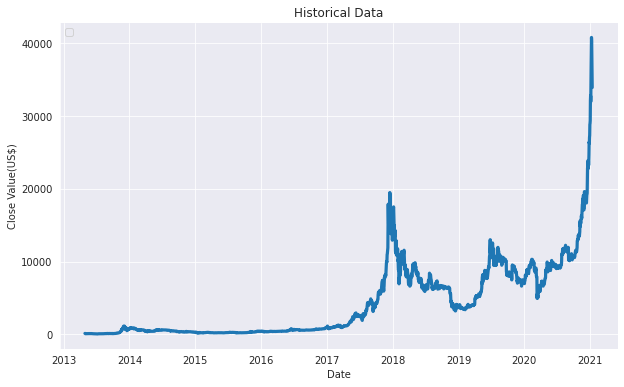

In [ ]:
# Plotting the dataset
plot_fig = plot_figure("Date", "Close Value(US$)", "Historical Data", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)
sns.set_context("paper", font_scale=2.1, rc={"lines.linewidth": 3.2})
sns.lineplot(data=crypto_dataframe, x="Date", y="Close")
horizontalalignment='center'
sns.despine()

In [ ]:
crypto_dataframe[next_close] = crypto_dataframe['Close'].shift(-1,fill_value=0)

In [ ]:
crypto_dataframe.drop(crypto_dataframe.tail(1).index,inplace=True)

In [ ]:
crypto_dataframe = crypto_dataframe.drop(columns=['Close'])

In [ ]:
crypto_dataframe = crypto_dataframe.set_index('Date')

In [ ]:
crypto_dataframe.tail()

,Open,High,Low,Volume,MarketCap,FUTURE_CLOSE
Date,,,,,,
2021-01-07,36833.87,40180.37,36491.19,8.476214e+10,7.320000e+11,40797.61
2021-01-08,39381.77,41946.74,36838.64,8.810752e+10,7.590000e+11,40254.55
2021-01-09,40788.64,41436.35,38980.88,6.198416e+10,7.490000e+11,38356.44
2021-01-10,40254.22,41420.19,35984.63,7.998075e+10,7.130000e+11,35566.66
2021-01-11,38346.53,38346.53,30549.60,1.233210e+11,6.614570e+11,33922.96


In [ ]:
# Train-Test Split(80%-20%)
training_size = int( len (crypto_dataframe) * 0.80)
training_dataset, testing_dataset = crypto_dataframe.iloc[:training_size],crypto_dataframe.iloc[training_size:]

No handles with labels found to put in legend.


Dimension of train data:  (2252, 6)
Dimension of test data:  (563, 6)


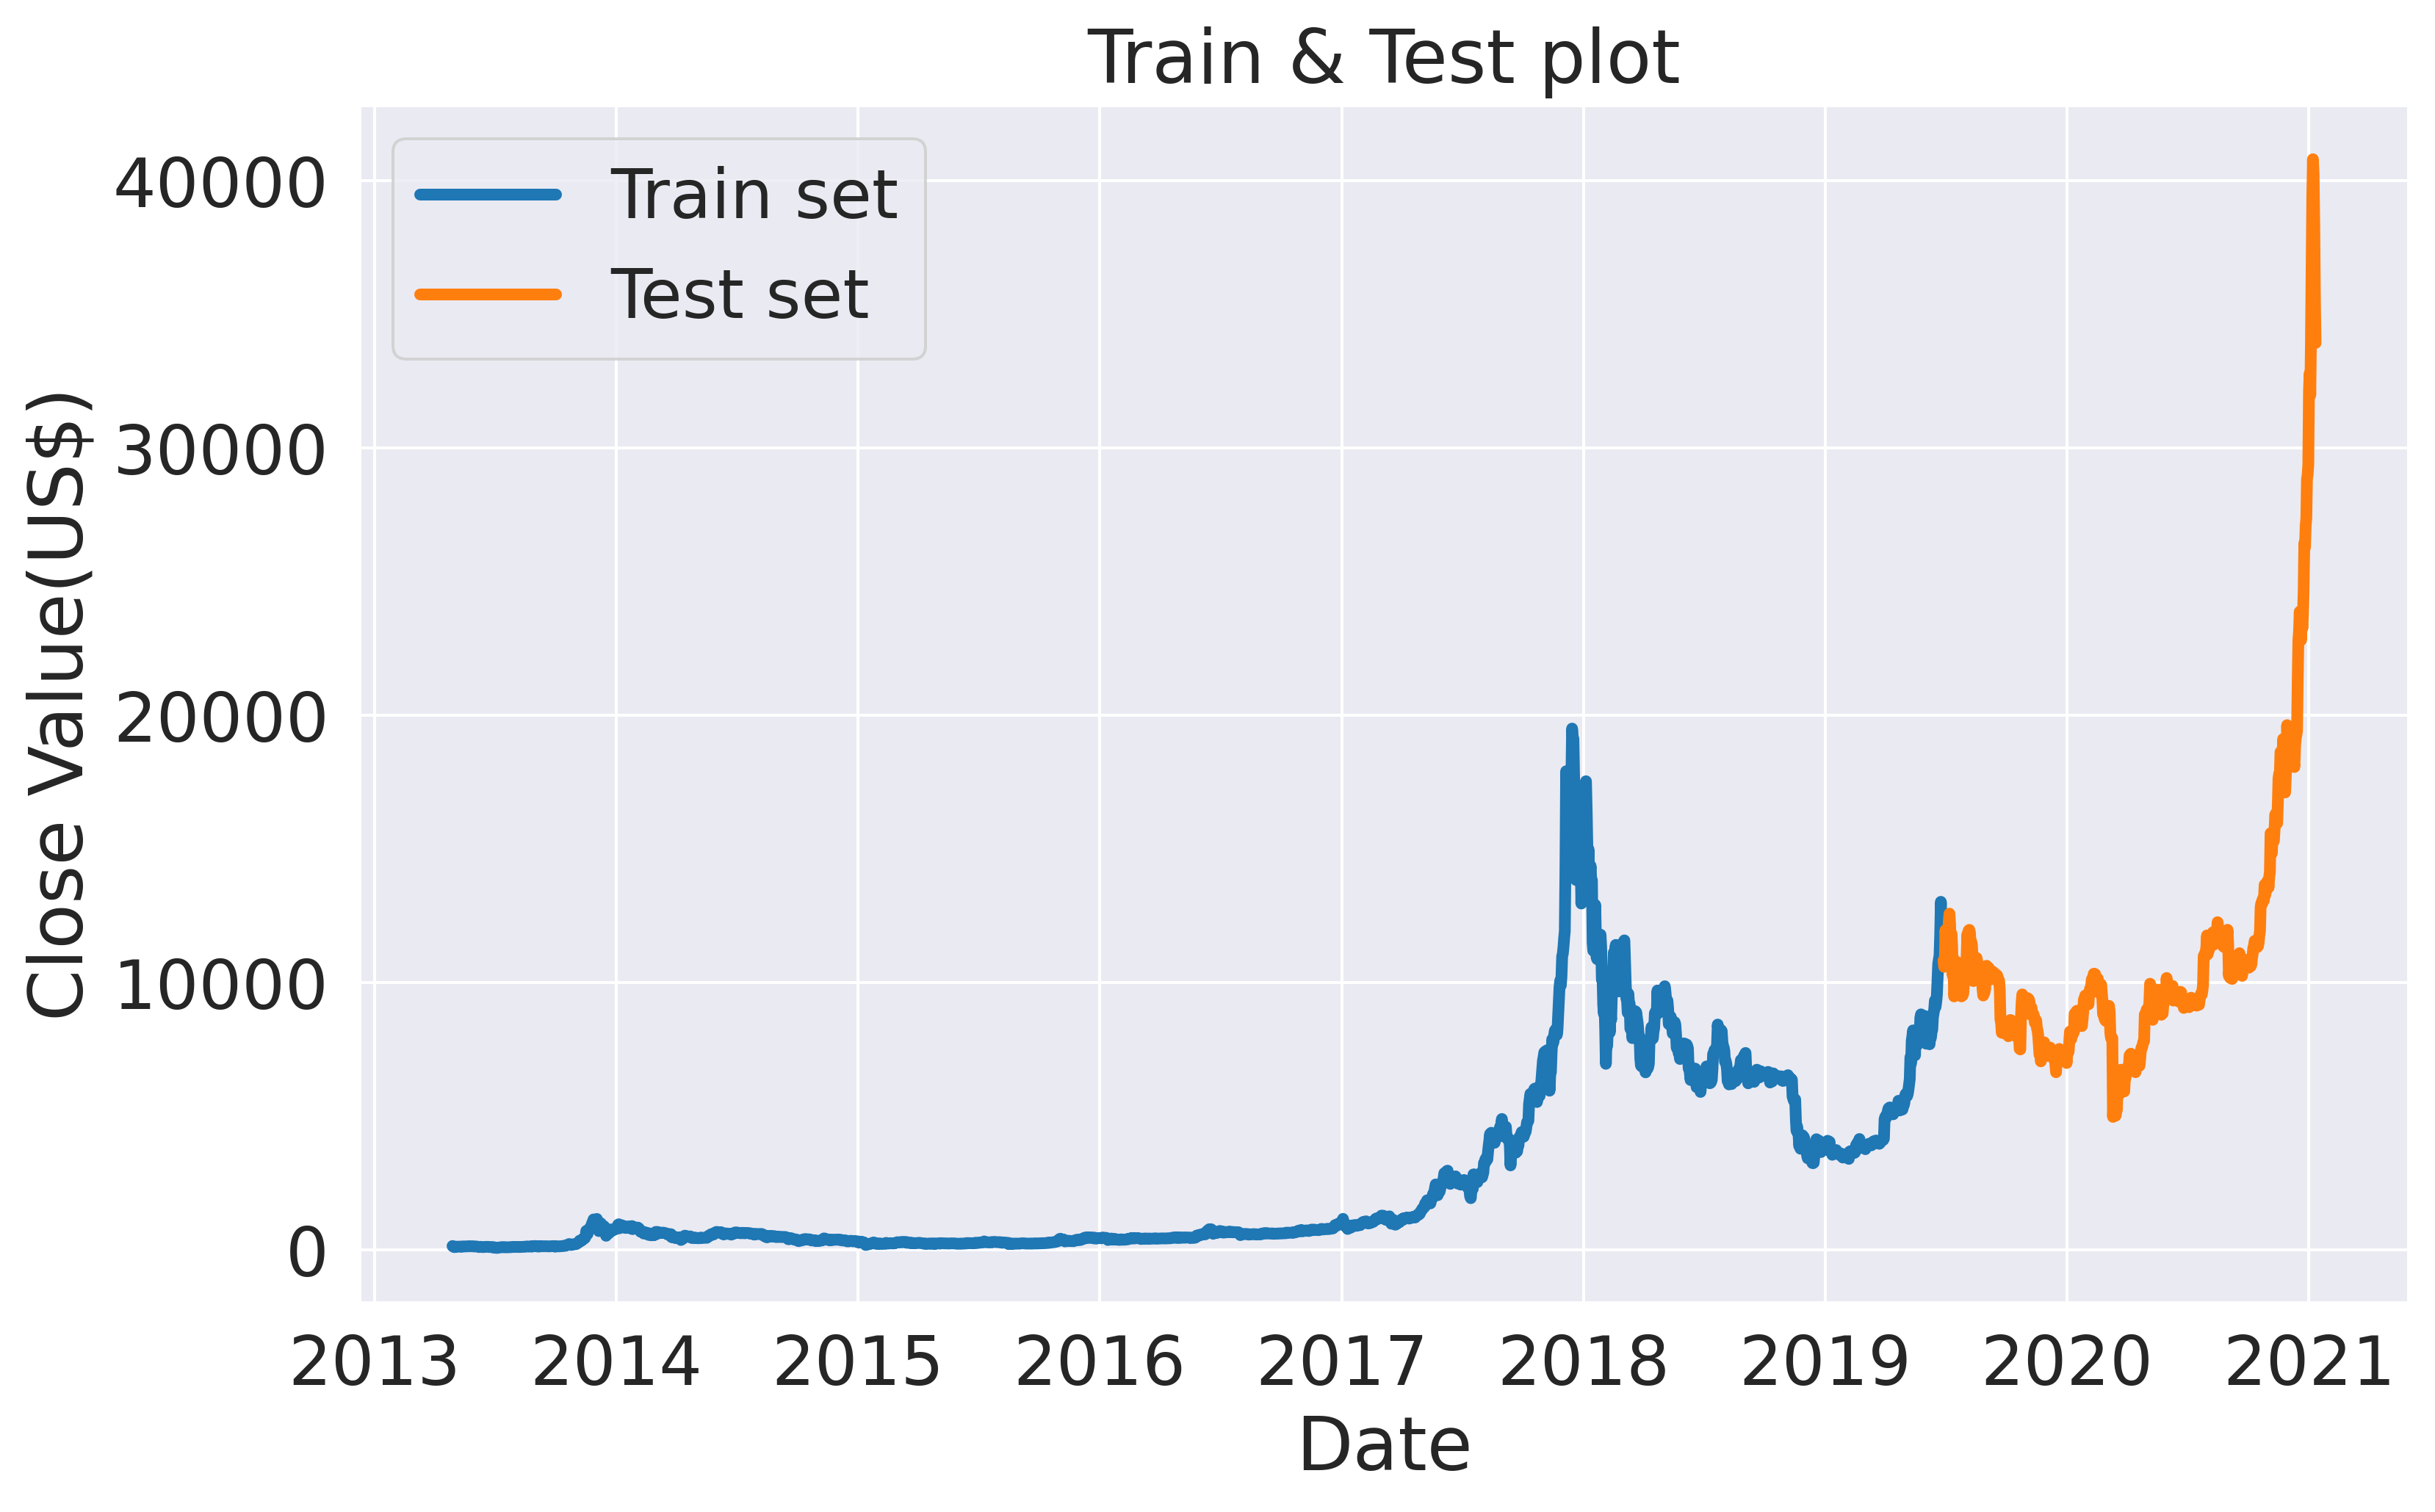

In [ ]:
plt_fig = plot_figure("Date", "Close Value(US$)", "Train & Test plot", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)

plt_fig.plot(training_dataset.FUTURE_CLOSE)
plt_fig.plot(testing_dataset.FUTURE_CLOSE)
plt_fig.legend(['Training dataset', 'Testesting dataset'], loc='upper left')

print('Shape of training_dataset: ',training_dataset.shape)
print('Shape of testing_dataset: ', testing_dataset.shape)

In [ ]:
# Splitting training_dataset into Predictors and outcomes
X_train = training_dataset.drop(next_close, axis = 1)
y_train = training_dataset.loc[:,[next_close]]

# Splitting testing_dataset into Predictors and outcomes
X_test = testing_dataset.drop(next_close, axis = 1)
y_test = testing_dataset.loc[:,[next_close]]

In [ ]:
min_max_scaler = MinMaxScaler(feature_range = (-1,1))

# Fitting MinMaxScaler to Trainset(X_train,y_train)
predictor_scaler = min_max_scaler.fit(X_train)
outcome_scaler = min_max_scaler.fit(y_train)

# Scaler in trainset
y_norm_train = outcome_scaler.transform(y_train)
x_norm_train = predictor_scaler.transform(X_train)

# Scaler in testset
y_norm_test = outcome_scaler.transform(y_test)
x_norm_test = predictor_scaler.transform(X_test)

***DATA TRANSFORMATION***

In [ ]:
def transform_dataset (X_array, y_array, time_steps = 1):
    X_transform, y_transform = [], []
    for i in range(len(X_array) - time_steps):
        output = X_array[i:i+time_steps, :]
        X_transform.append(output)
        y_transform.append(y_array[i+time_steps])

    return np.array(X_transform), np.array(y_transform)


X_test, y_test = transform_dataset(x_norm_test, y_norm_test, TIME_STEPS)
X_train, y_train = transform_dataset(x_norm_train, y_norm_train, TIME_STEPS)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)
print('X_train: ', X_train)

X_train.shape:  (2242, 10, 5)
y_train.shape:  (2242, 1)
X_test.shape:  (553, 10, 5)
y_test.shape:  (553, 1)
X_train:  [[[-0.99320462 -0.99271226 -0.99275778 -1.         -0.9949399 ]
  [-0.99221942 -0.99276822 -0.99275249 -1.         -0.9953136 ]
  [-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  ...
  [-0.995107   -0.99499361 -0.99565171 -1.         -0.99711477]
  [-0.99549139 -0.99611481 -0.99659731 -1.         -0.99716645]
  [-0.99576448 -0.99588097 -0.99533862 -1.         -0.99702265]]

 [[-0.99221942 -0.99276822 -0.99275249 -1.         -0.9953136 ]
  [-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  [-0.99506577 -0.99489968 -0.9971706  -1.         -0.99760834]
  ...
  [-0.99549139 -0.99611481 -0.99659731 -1.         -0.99716645]
  [-0.99576448 -0.99588097 -0.99533862 -1.         -0.99702265]
  [-0.99539349 -0.99611281 -0.99537458 -1.         -0.99708098]]

 [[-0.99273469 -0.99347171 -0.99553747 -1.         -0.99680865]
  [-0.99506577 -0.99489968 -0.9971

***DATA MODELING***

*   Model Creation
*   Model Training
*   Hyperparameter Tune
*   Sequential and parallel architecture implementation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          27264       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          27264       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          27264       input_1[0][0]                    
______________________________________________________________________________________________

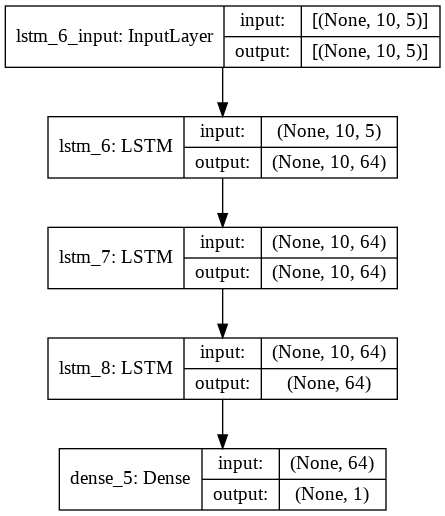

In [ ]:
# BiRNN Model using Functional API of Keras (Parallel)
def build_model_birnn_func(units, mt):
    input1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden1 = Bidirectional(mt(units = units) )(input1)

    hidden2 = Bidirectional(mt(units = units) )(input1)

    hidden3 = Bidirectional(mt(units = units) )(input1)

    hidden4 = keras.layers.concatenate([hidden1, hidden2,hidden3])
    output = Dense(1)(hidden4)

    parallelModel = Model(inputs=input1, outputs=output)

    parallelModel.compile(optimizer='adam',loss='mse')
    return parallelModel


# Building the Sequential Bidirectional model
def build_model_birnn(units, mt):
    sequentialModel = Sequential()
    sequentialModel.add(Bidirectional(mt(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    sequentialModel.add(Bidirectional(mt(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))

    sequentialModel.add(Bidirectional(mt(units = units)))
    sequentialModel.add(Dense(1))

    sequentialModel.compile(optimizer='adam', loss='mse')
    return sequentialModel


# Building LSTM or GRU Sequential model
def build_model_sequential(units, mt):
    sequentialModel = Sequential()

    sequentialModel.add(mt(units, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]))  # returns a sequence of vectors of dimension 32
    sequentialModel.add(mt(units, return_sequences=True))  # returns a sequence of vectors of dimension 32
    sequentialModel.add(mt(units))  # return a single vector of dimension 32

    sequentialModel.add(Dense(1))

    sequentialModel.compile( optimizer='adam',loss='mse')
    return sequentialModel

# Functional API BiRNN
func_biGruModel = build_model_birnn_func(total_units, GRU)
func_biLstmModel = build_model_birnn_func(total_units, LSTM)


# BiRNN Sequential GRU and LSTM
biGruModel = build_model_birnn(total_units, GRU)
biLstmModel = build_model_birnn(total_units, LSTM)


# GRU and LSTM Sequential
gruModel = build_model_sequential(total_units, GRU)
lstmModel = build_model_sequential(total_units, LSTM)

# Model summary and plot
func_biGruModel.summary()
plot_model(func_biGruModel, to_file='saved_data/func_biGruModel.png', show_shapes=True, show_layer_names=True)

func_biLstmModel.summary()
plot_model(func_biLstmModel, to_file='saved_data/func_biLstmModel.png', show_shapes=True, show_layer_names=True)

biGruModel.summary()
plot_model(biGruModel, to_file='saved_data/biGruModel.png', show_shapes=True, show_layer_names=True)

biLstmModel.summary()
plot_model(biLstmModel, to_file='saved_data/biLstmModel.png', show_shapes=True, show_layer_names=True)

gruModel.summary()
plot_model(gruModel, to_file='saved_data/gruModel.png', show_shapes=True, show_layer_names=True)

lstmModel.summary()
plot_model(lstmModel, to_file='saved_data/lstmModel.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [csv_logger,early_stop])
    return history




history_bigru_func = fit_model(func_biGruModel)
history_biLstm_func = fit_model(func_biLstmModel)
history_bigru = fit_model(biGruModel)
history_biLstm = fit_model(biLstmModel)
history_gru = fit_model(gruModel)
history_lstm = fit_model(lstmModel)

Epoch 1/10
57/57 [==============================] - 16s 75ms/step - loss: 0.0394 - val_loss: 0.0242
Epoch 2/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0161 - val_loss: 0.0032
Epoch 3/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0067 - val_loss: 0.0246
Epoch 4/10
57/57 [==============================] - 2s 35ms/step - loss: 0.0132 - val_loss: 0.0029
Epoch 5/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0057 - val_loss: 0.0217
Epoch 6/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0117 - val_loss: 0.0028
Epoch 7/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0050 - val_loss: 0.0189
Epoch 8/10
57/57 [==============================] - 2s 34ms/step - loss: 0.0104 - val_loss: 0.0025
Epoch 9/10
57/57 [==============================] - 2s 35ms/step - loss: 0.0042 - val_loss: 0.0154
Epoch 10/10
57/57 [==============================] - 2s 35ms/step - loss: 0.0086 - val_loss: 0.0025
Epoch 1/

In [ ]:
y_test = min_max_scaler.inverse_transform(y_test)
y_train = min_max_scaler.inverse_transform(y_train)

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = min_max_scaler.inverse_transform(prediction)
    return prediction

prediction_bigru_func = prediction(func_biGruModel)
prediction_biLstm_func = prediction(func_biLstmModel)
prediction_bigru = prediction(biGruModel)
prediction_biLstm = prediction(biLstmModel)
prediction_gru = prediction(gruModel)
prediction_lstm = prediction(lstmModel)

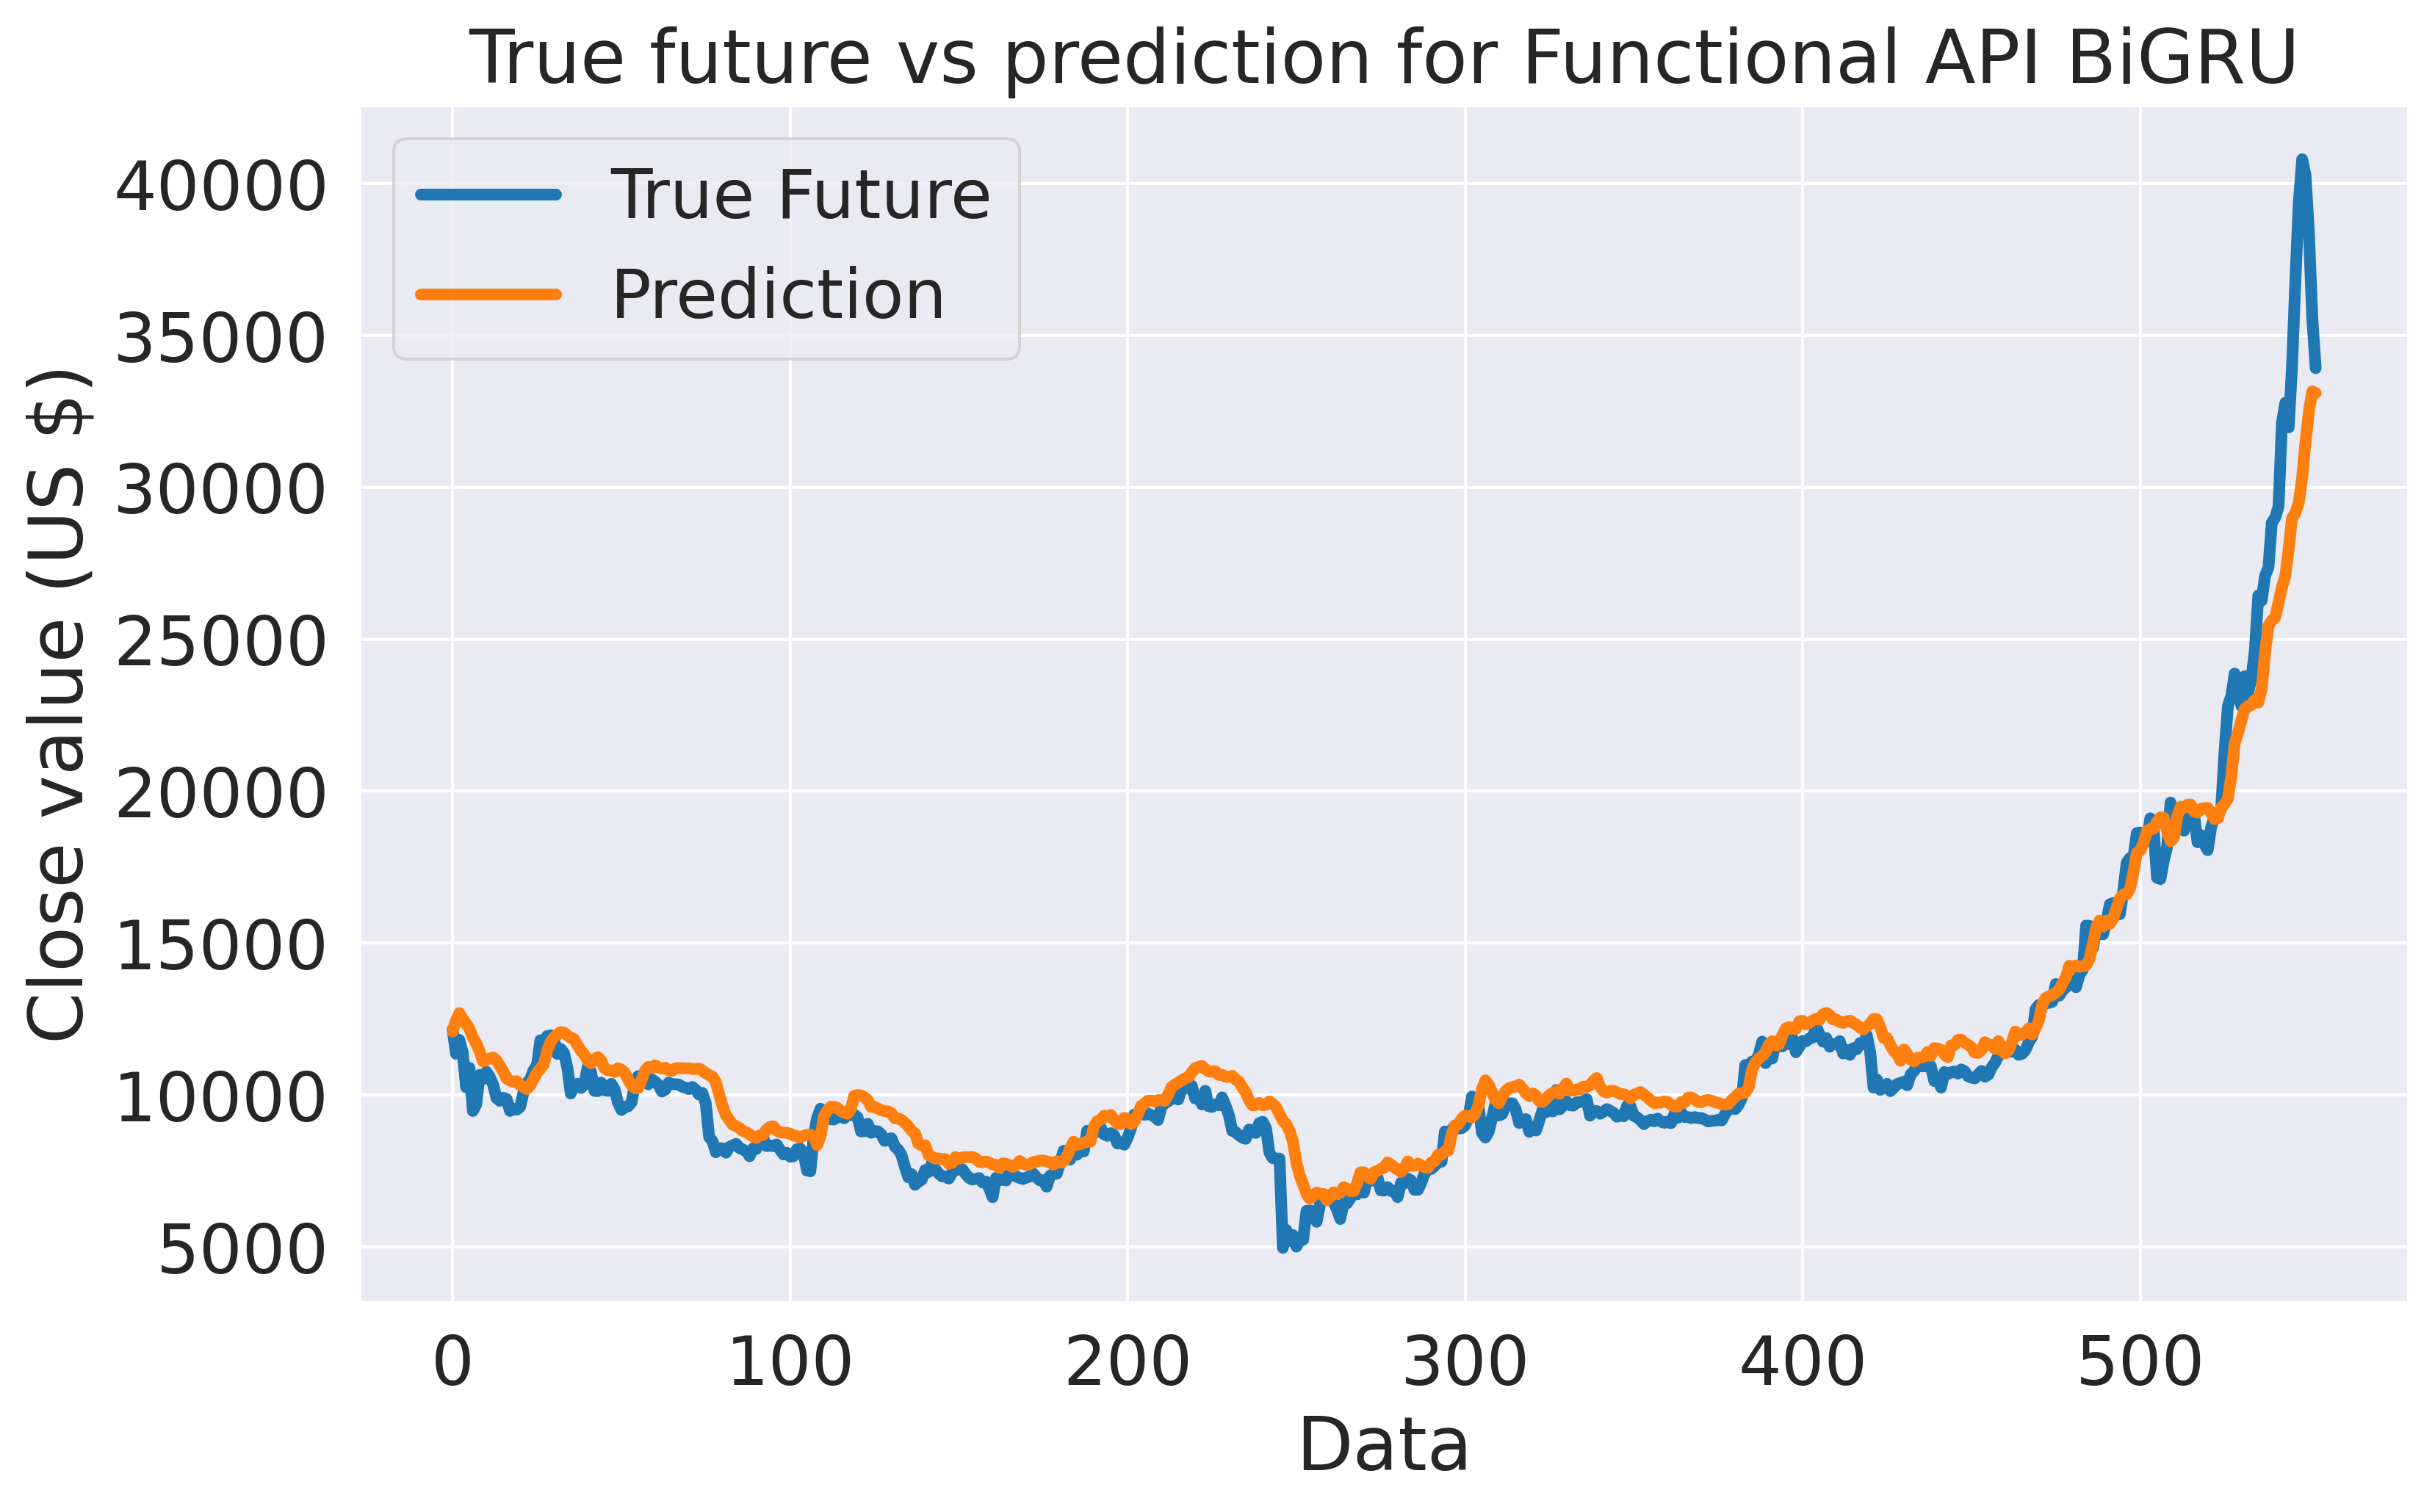

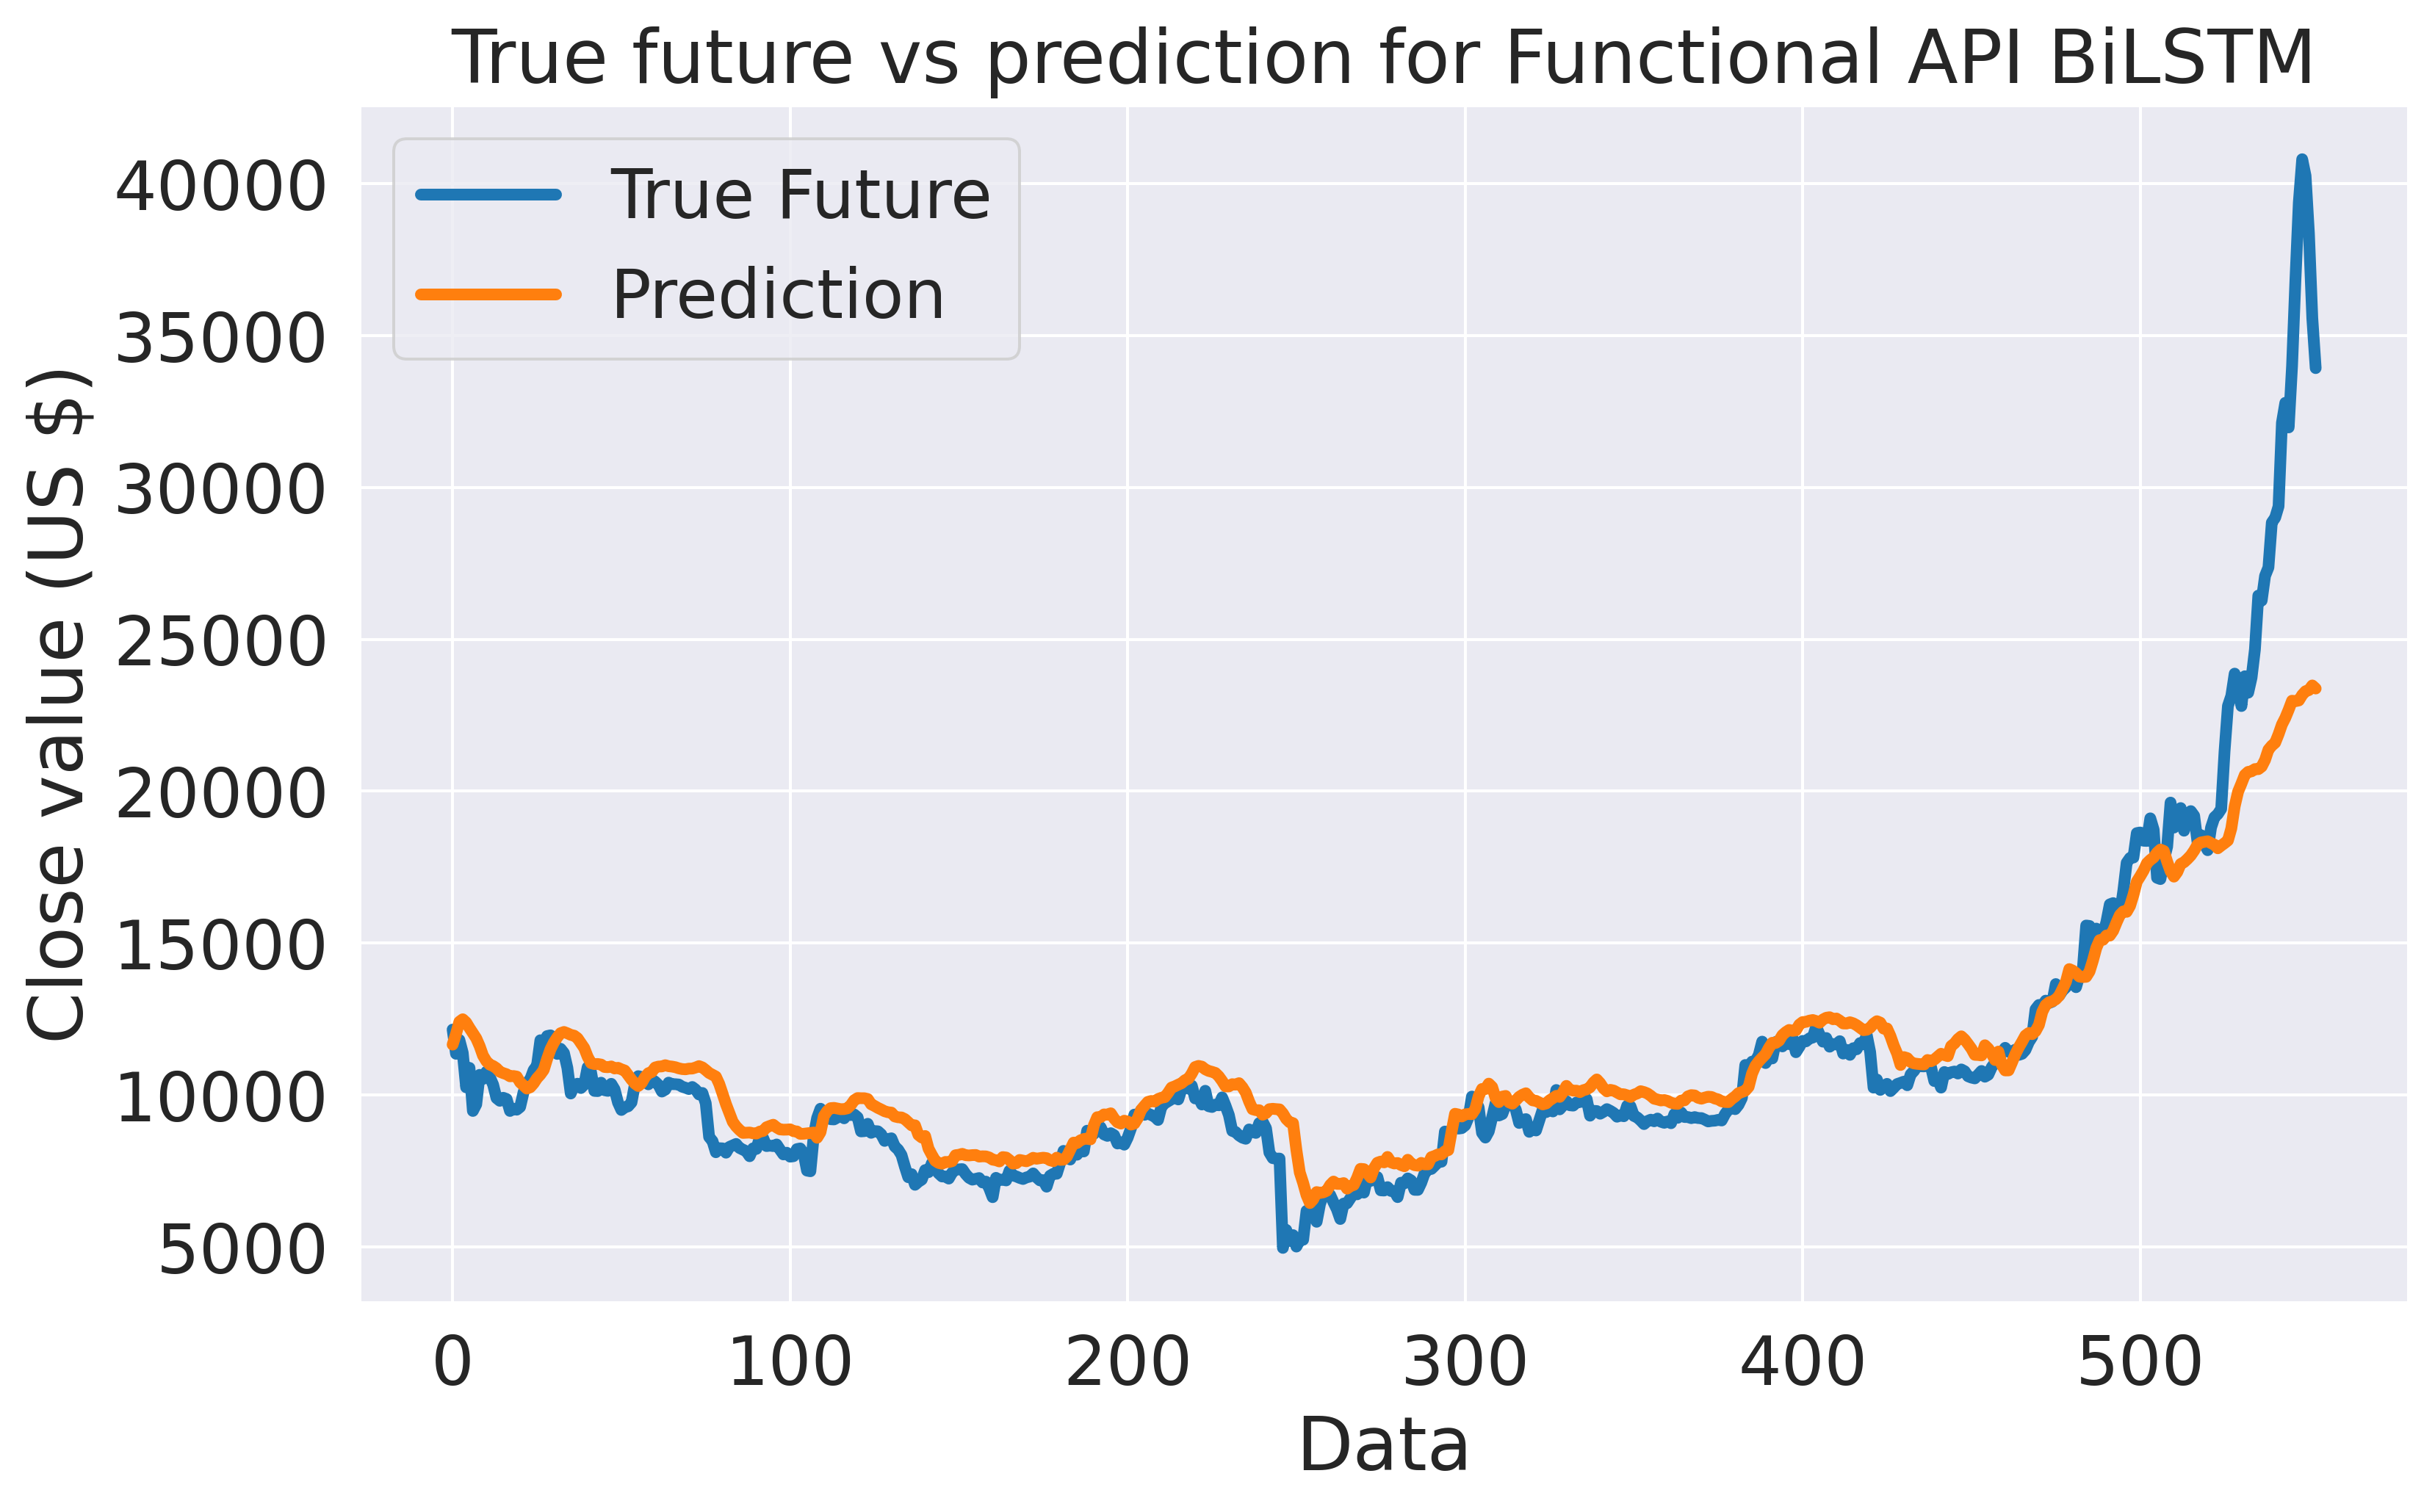

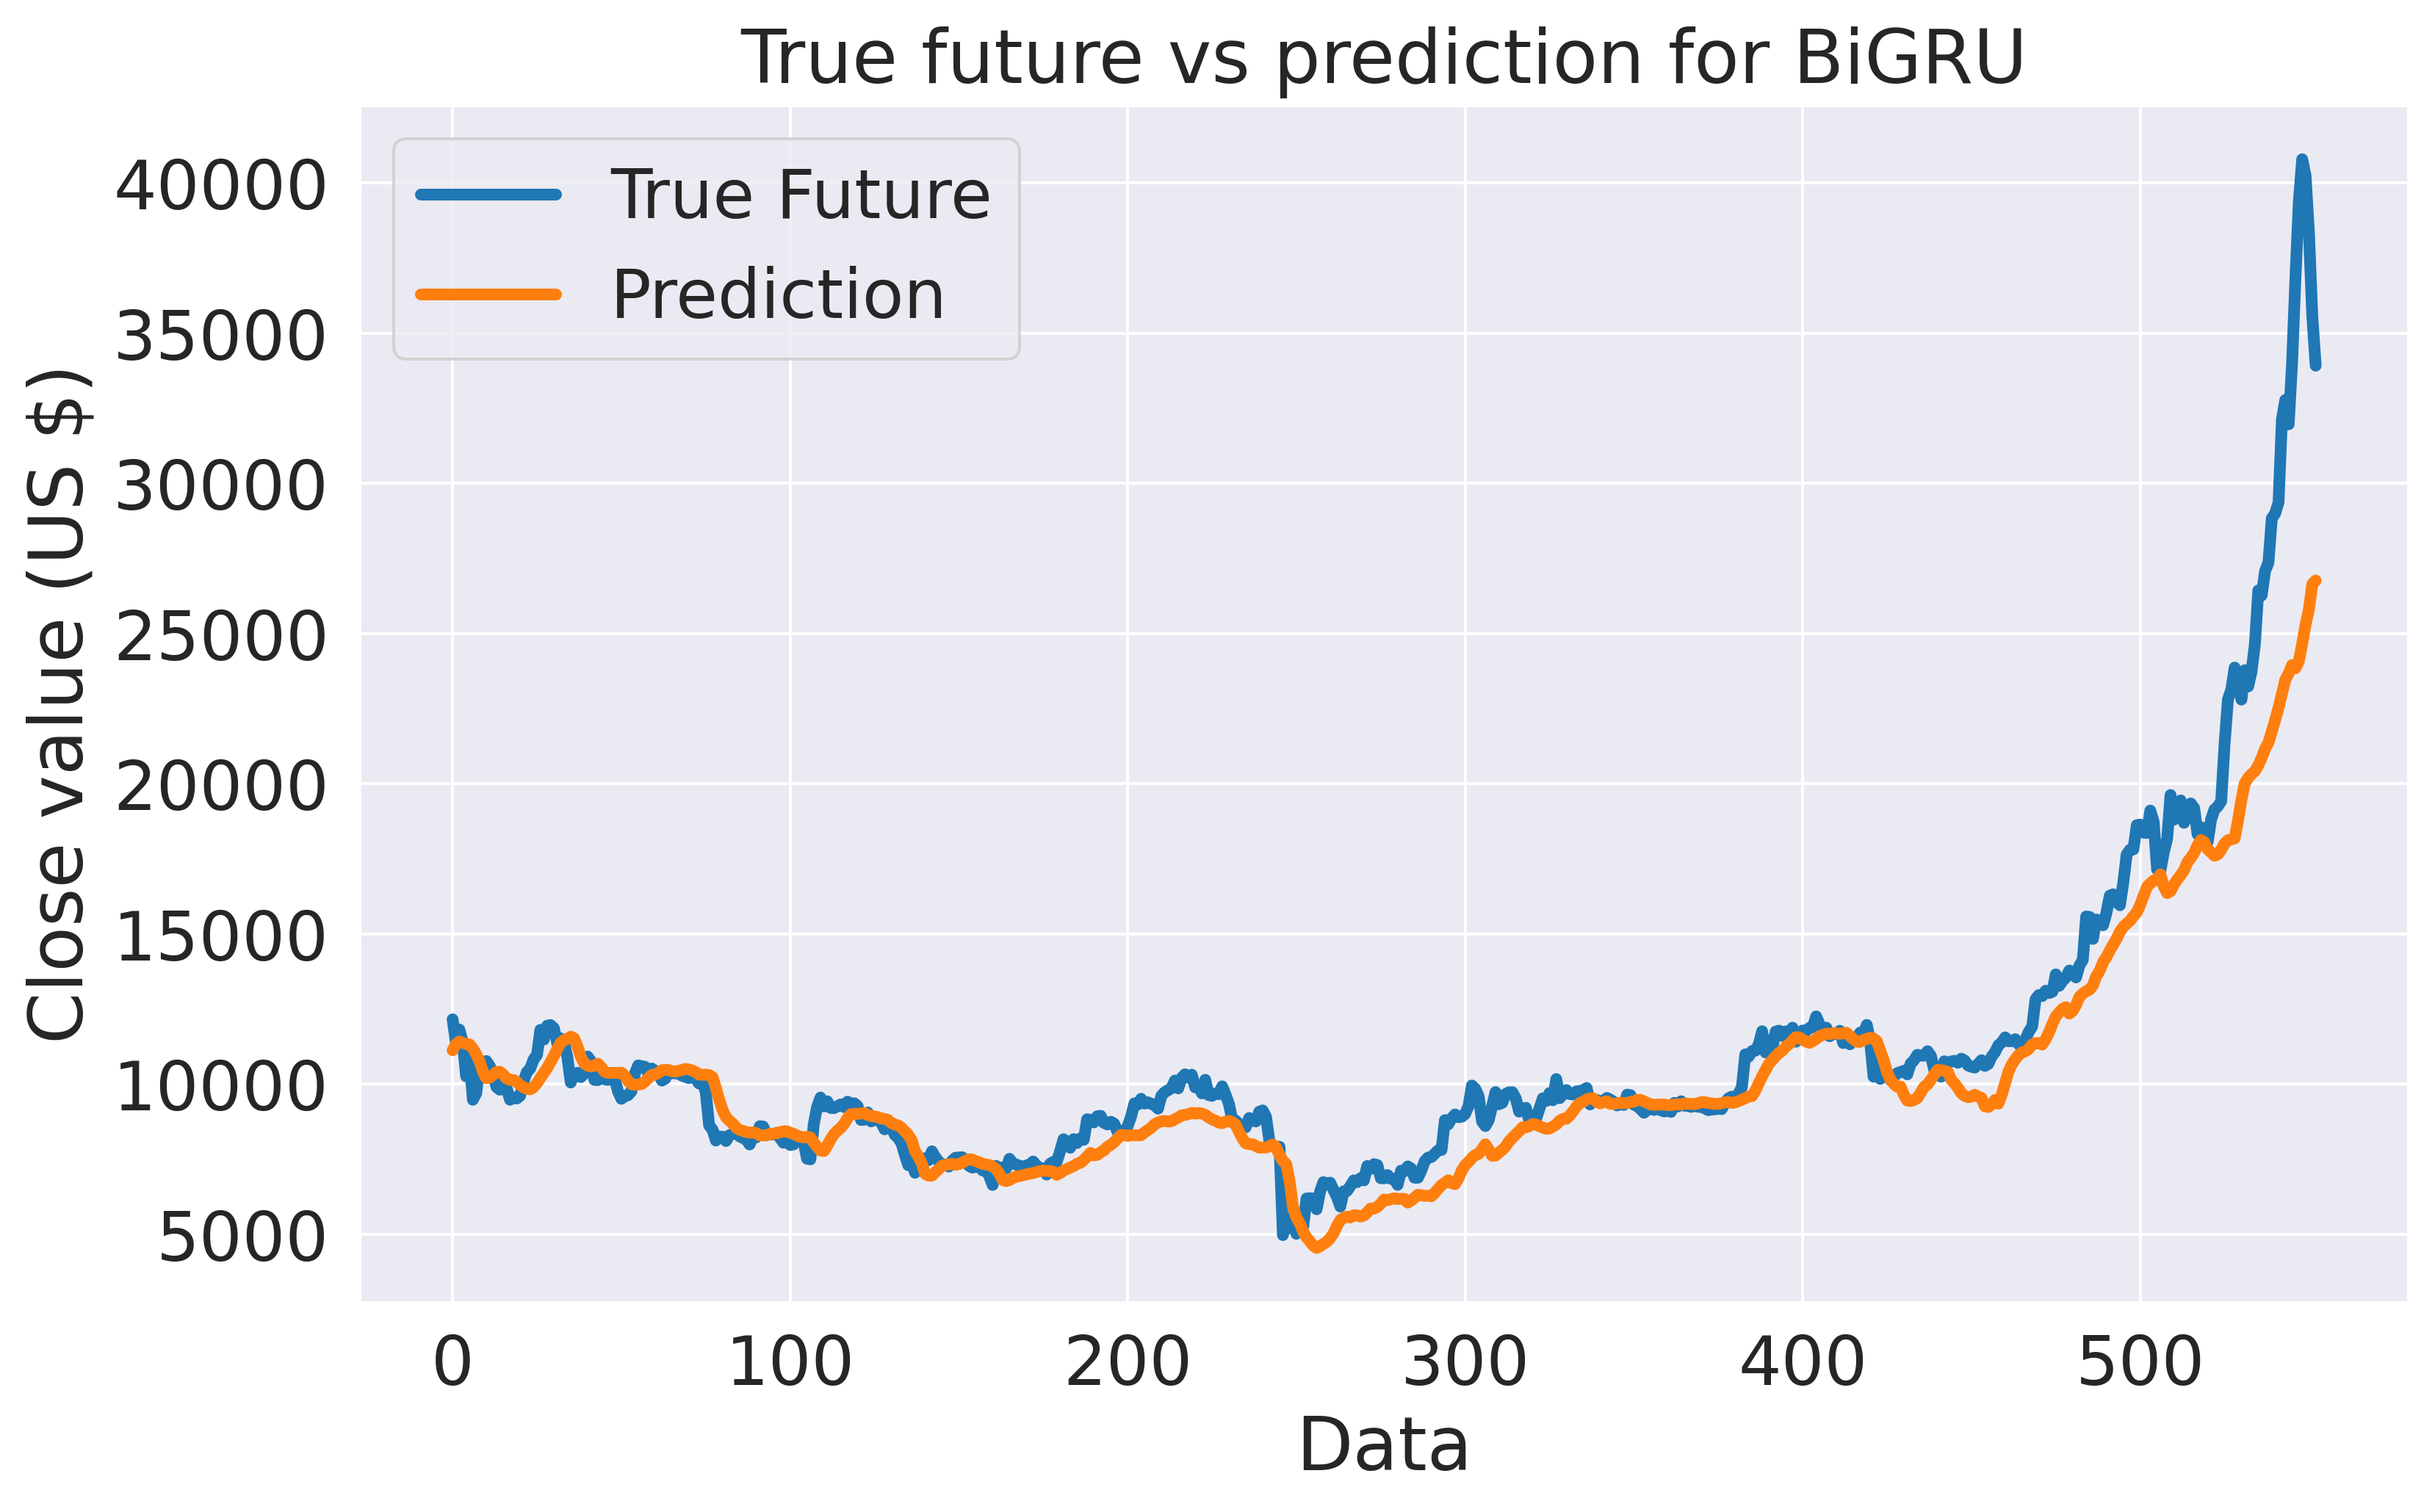

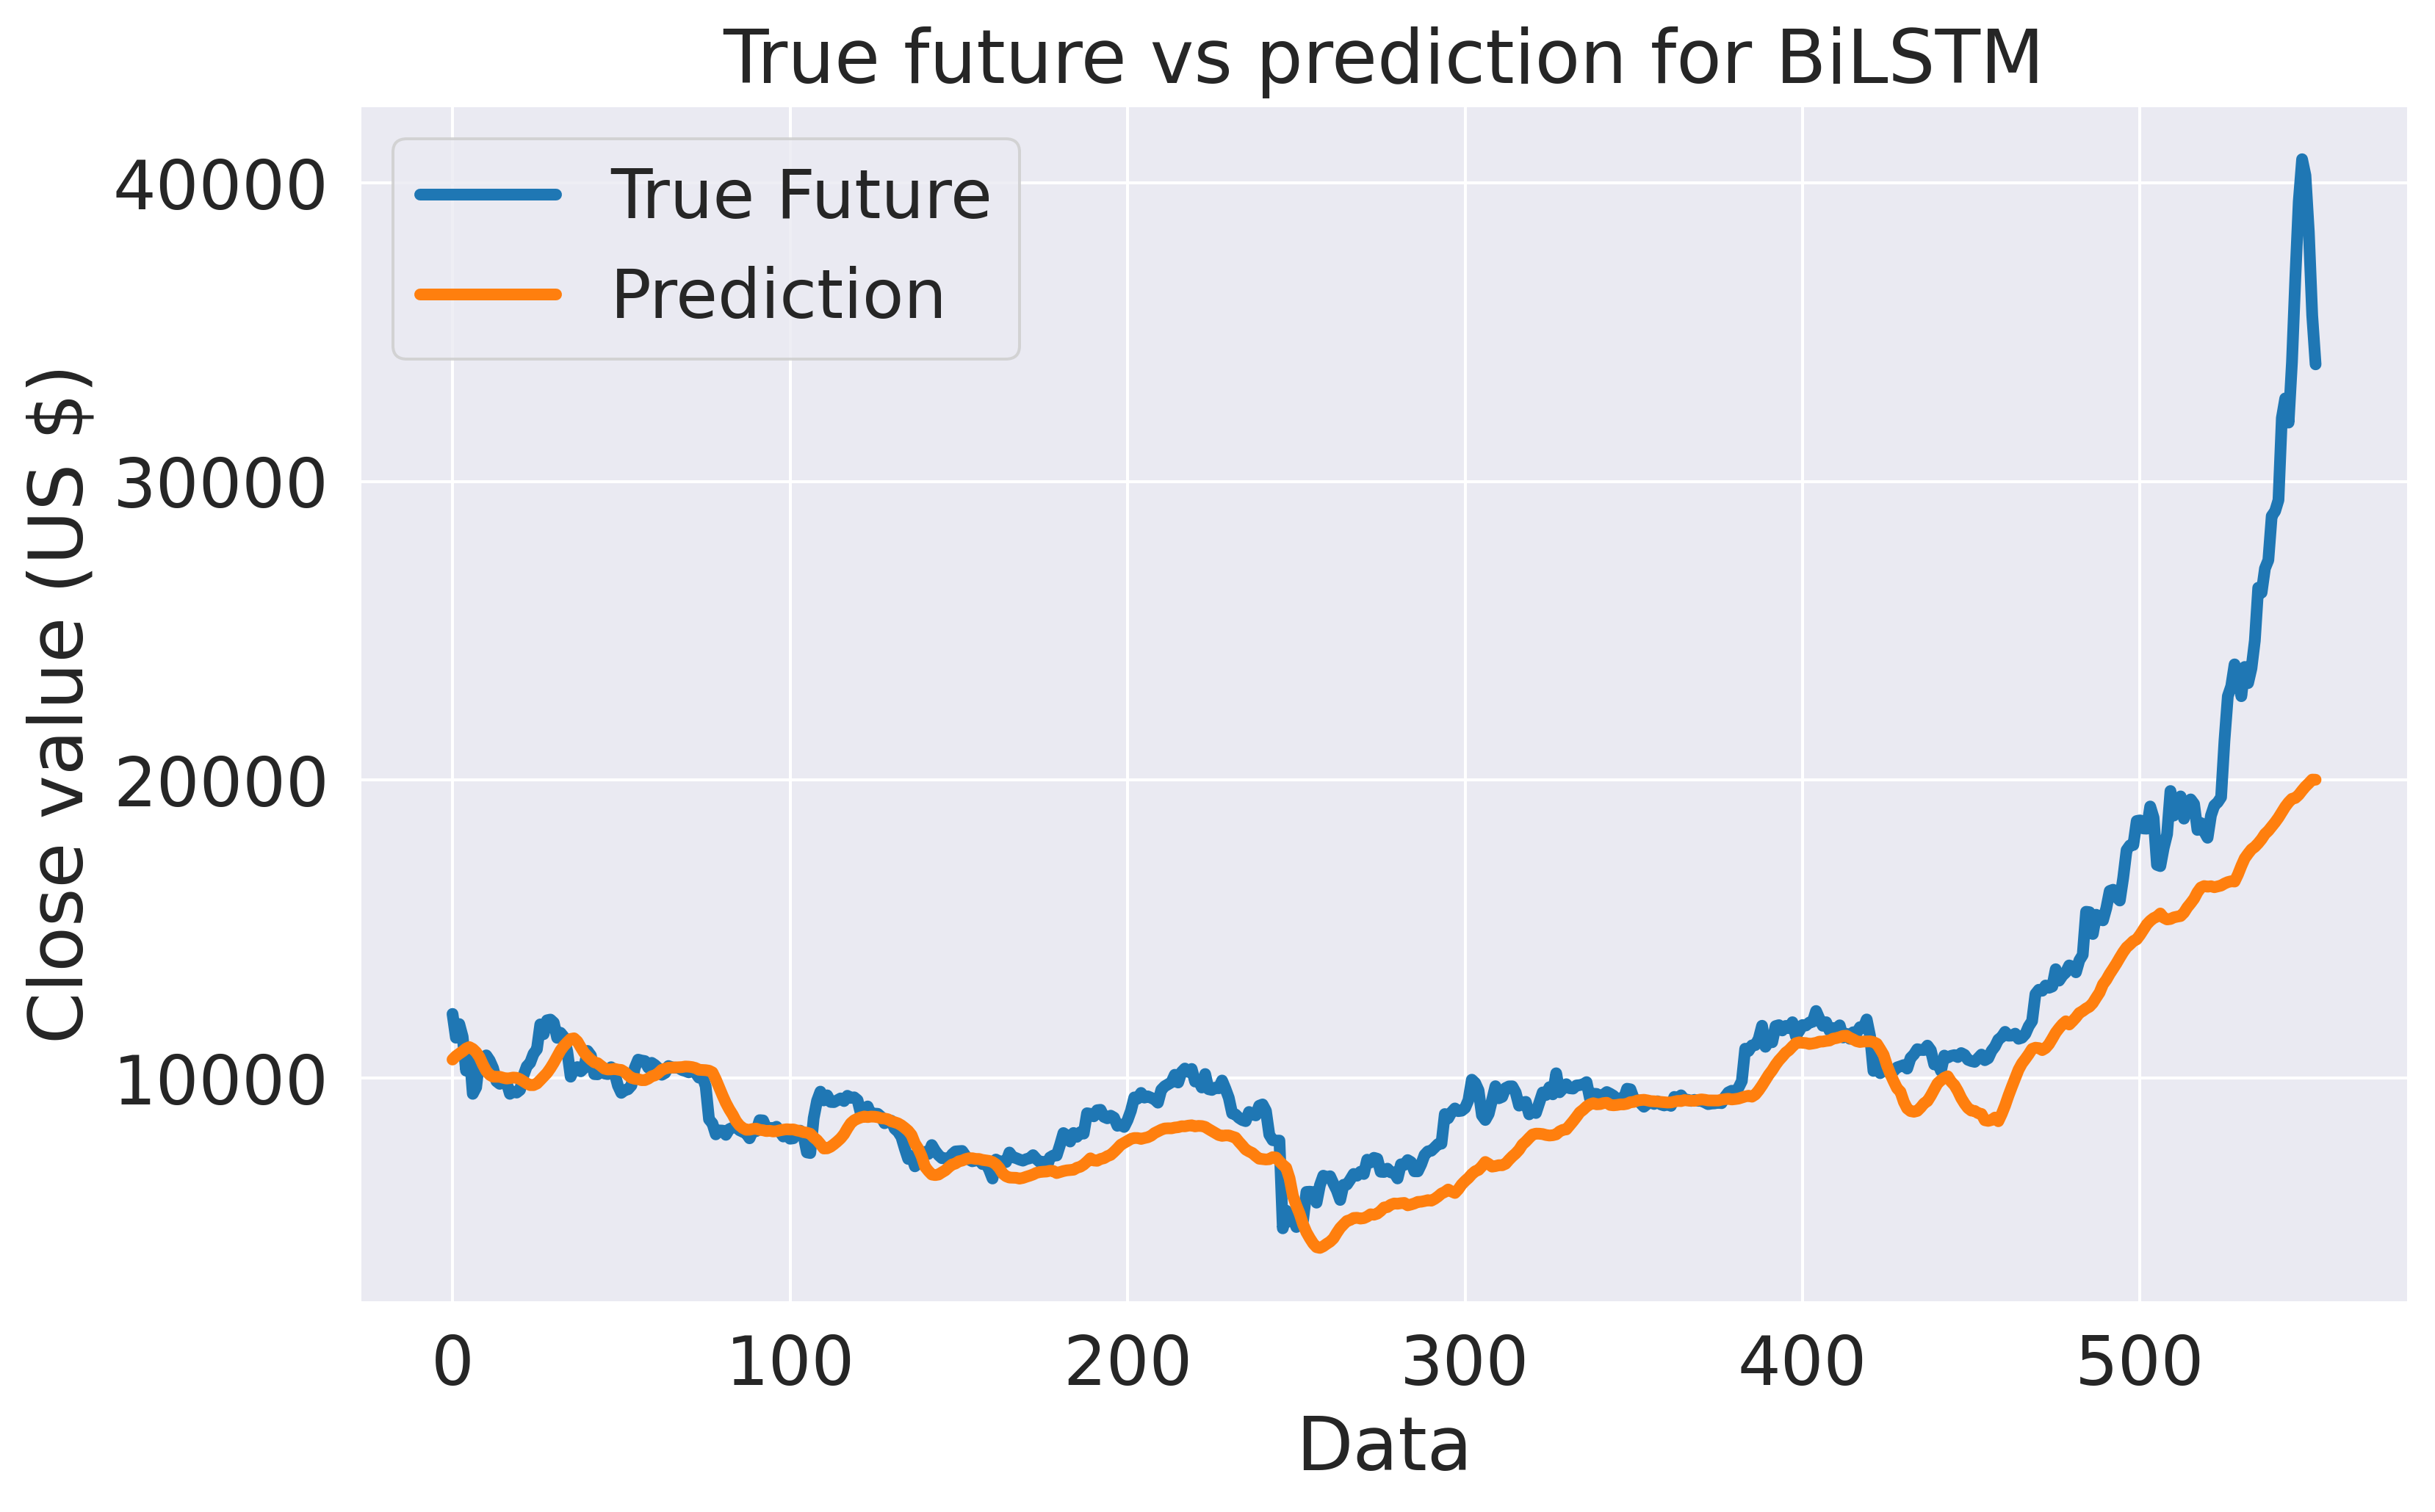

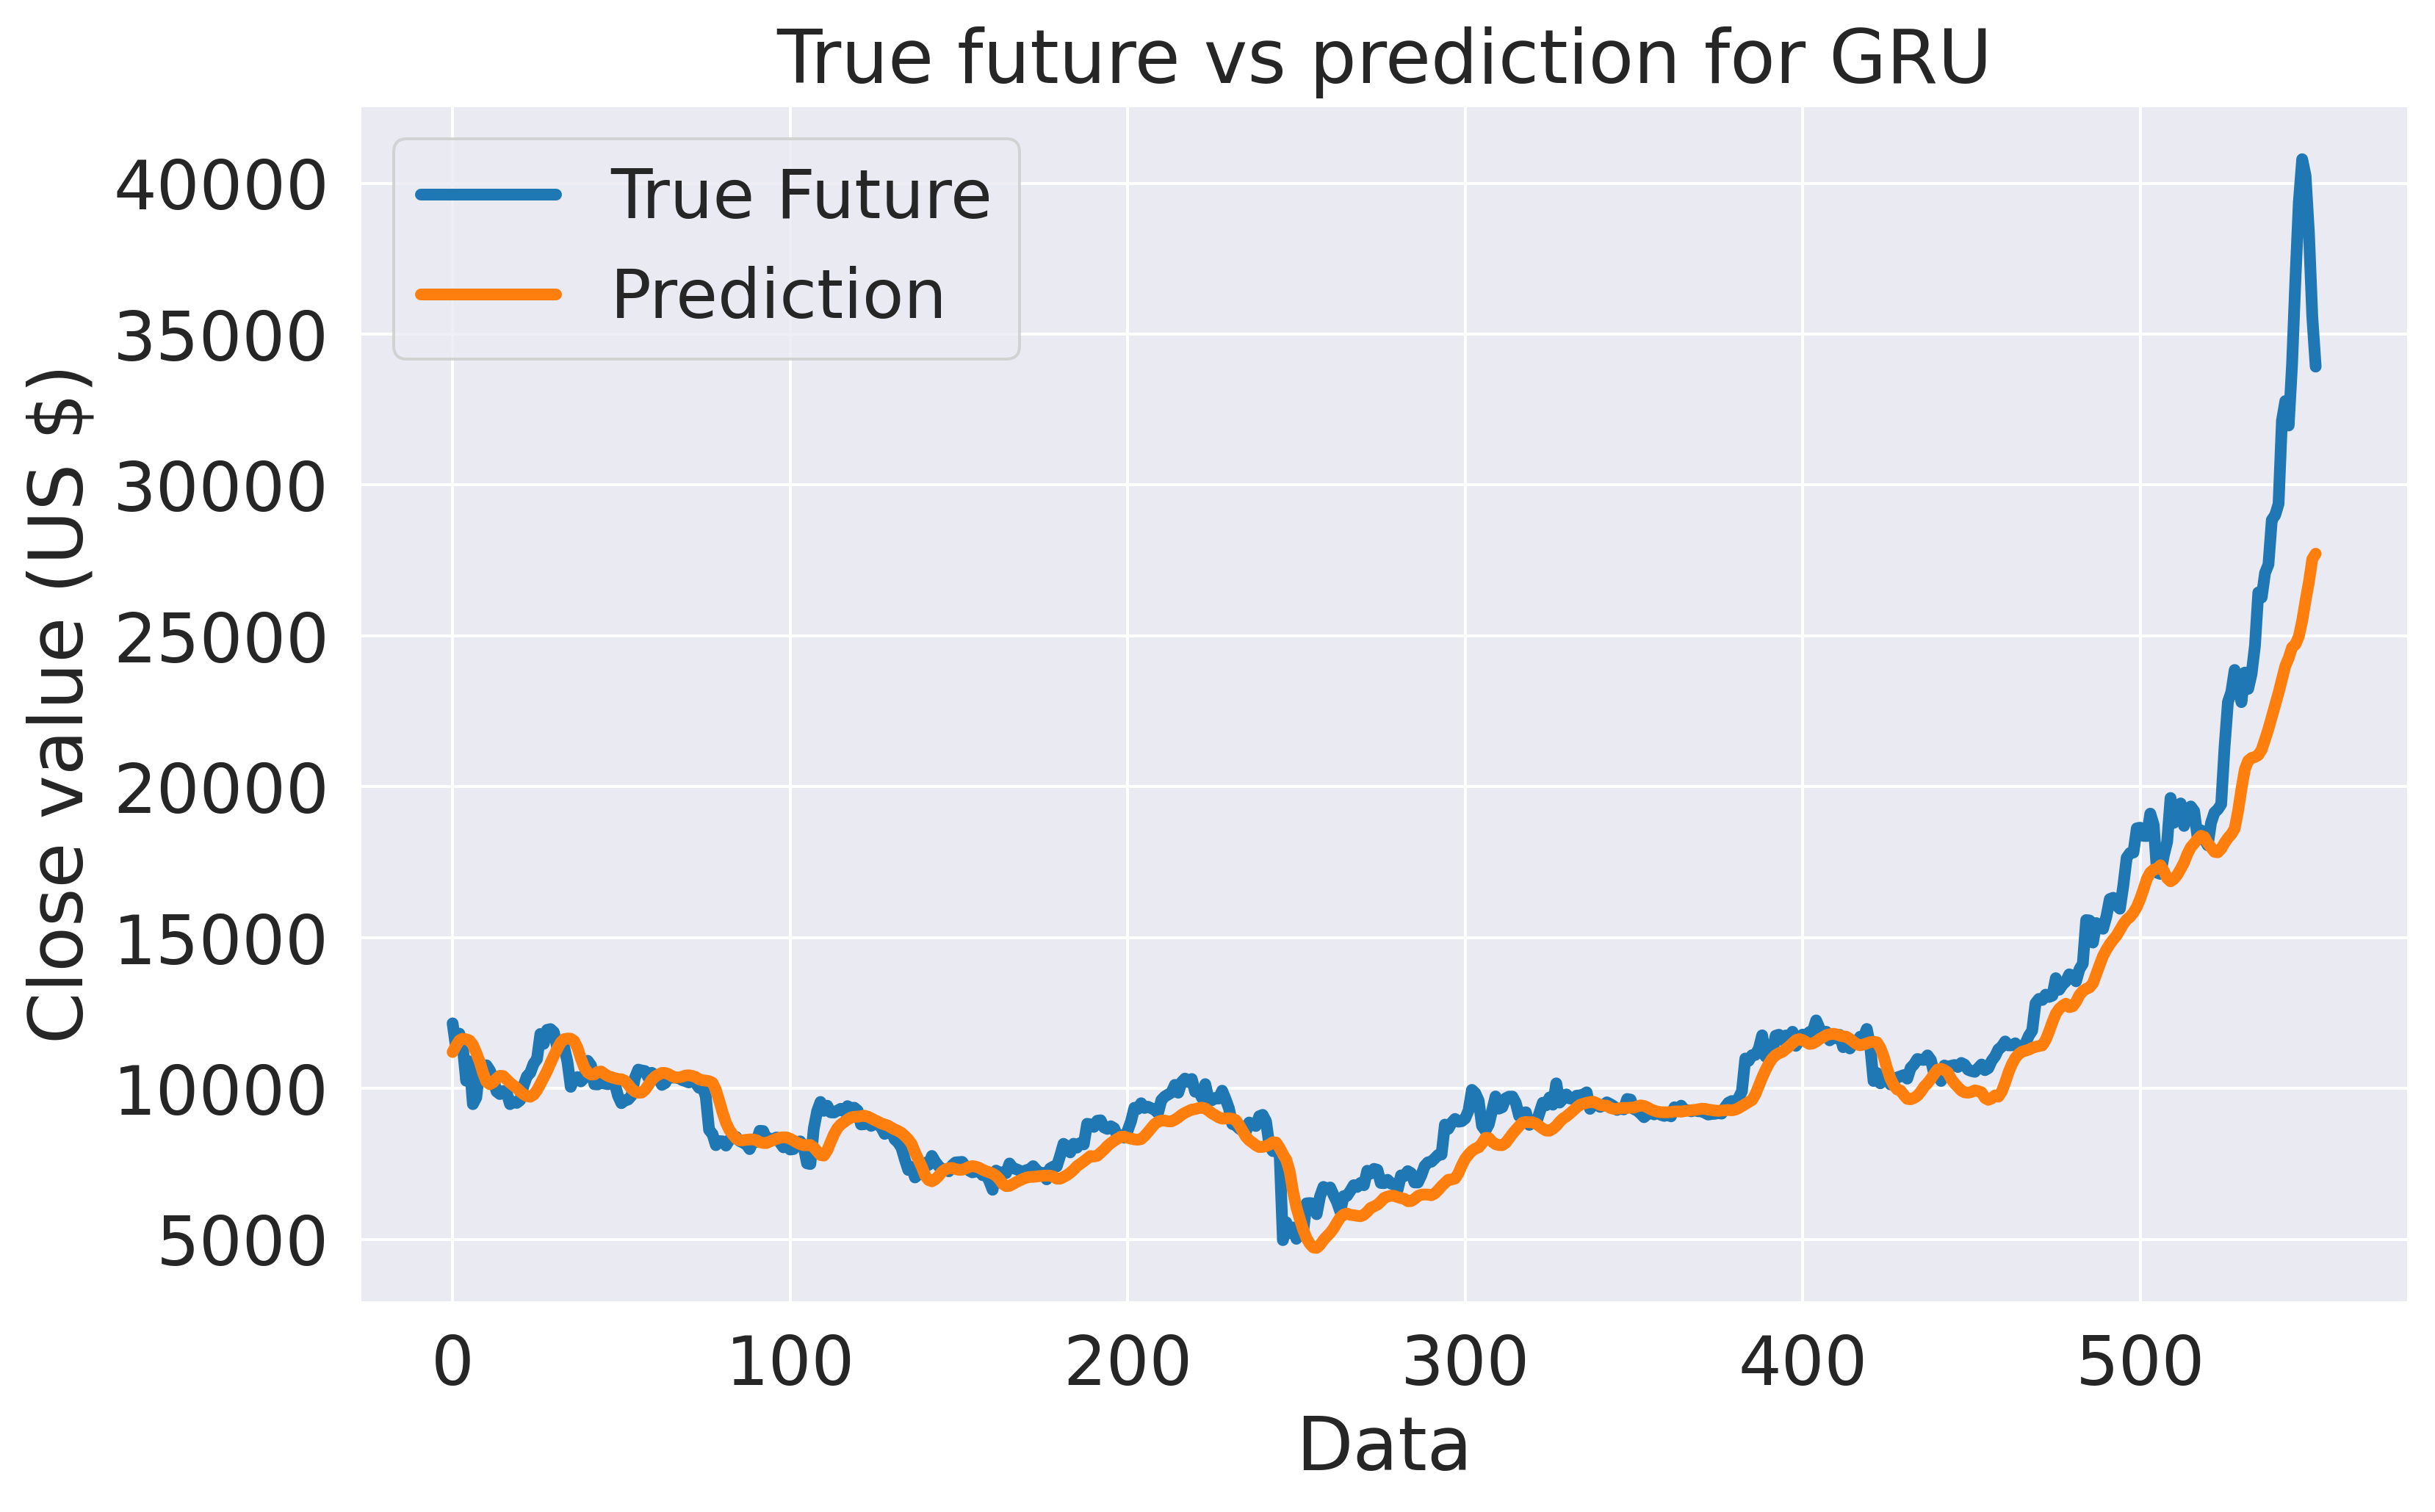

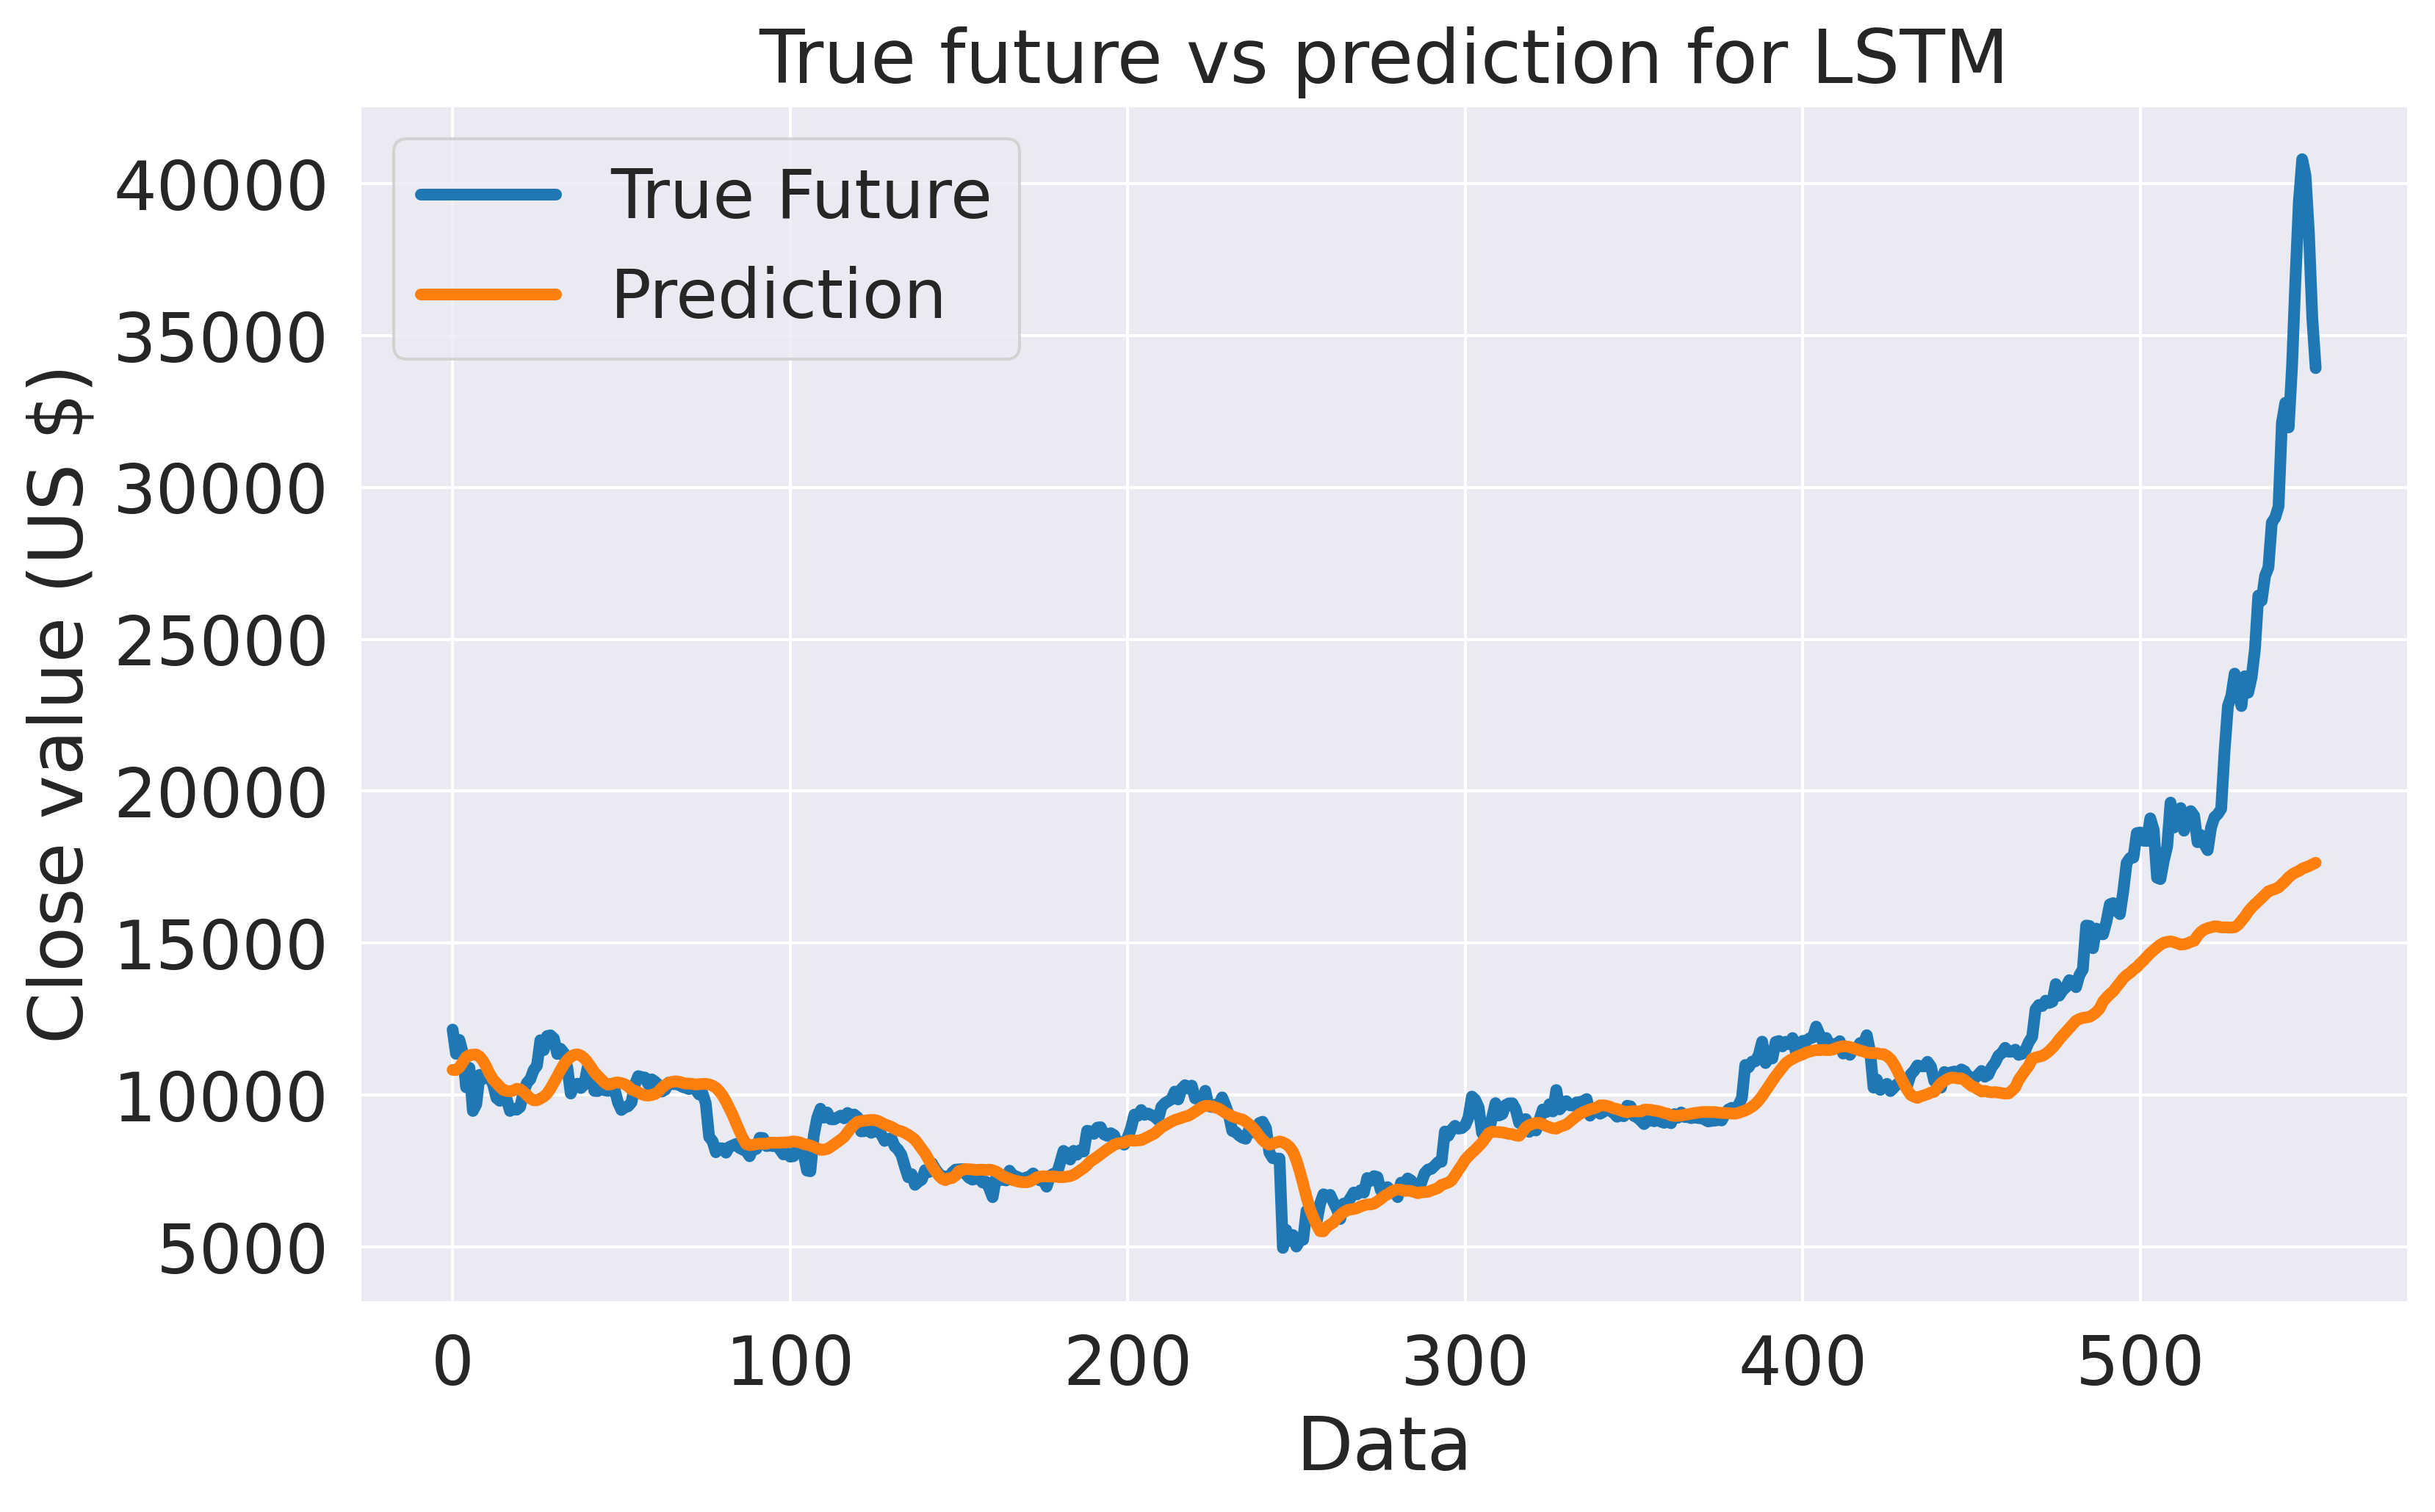

In [ ]:
def plot_future(prediction, model_name, y_test):

    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Data')
    plt.ylabel('Close value (US $)')


plot_future(prediction_bigru_func, 'Functional API BiGRU', y_test)
plot_future(prediction_biLstm_func, 'Functional API BiLSTM', y_test)
plot_future(prediction_bigru, 'BiGRU', y_test)
plot_future(prediction_biLstm, 'BiLSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)

In [ ]:

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()

    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    #mase = ((np.abs((actual - predictions)) / mae)


    print(model_name + ':')
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('Mean Percentage Error: {:.2f}'.format(mape))
    #print('Mean Absolute Scaled Error: {:.2f}'.format(mase))

    print('')


evaluate_prediction(prediction_bigru_func, y_test, 'Func Bidirectional GRU')
evaluate_prediction(prediction_biLstm_func, y_test, 'Func Bidirectional LSTM')
evaluate_prediction(prediction_bigru, y_test, 'Bidirectional GRU')
evaluate_prediction(prediction_biLstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

"""
corr_matrix = np.corrcoef(y_test, prediction_func_biLstm)
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)
"""

Func Bidirectional GRU:
Mean Absolute Error: 832.57
Root Mean Square Error: 1322.06
Mean Percentage Error: 7.77

Func Bidirectional LSTM:
Mean Absolute Error: 1098.90
Root Mean Square Error: 2260.79
Mean Percentage Error: 8.93

Bidirectional GRU:
Mean Absolute Error: 1094.67
Root Mean Square Error: 2111.94
Mean Percentage Error: 8.48

Bidirectional LSTM:
Mean Absolute Error: 1596.16
Root Mean Square Error: 3048.13
Mean Percentage Error: 12.01

GRU:
Mean Absolute Error: 972.89
Root Mean Square Error: 1942.86
Mean Percentage Error: 7.52

LSTM:
Mean Absolute Error: 1424.56
Root Mean Square Error: 3339.09
Mean Percentage Error: 9.35



'\ncorr_matrix = np.corrcoef(y_test, prediction_func_biLstm)\ncorr = corr_matrix[0,1]\nR_sq = corr**2\n \nprint(R_sq)\n'

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.

biLstmModel.save("saved_data/biLstmModel_64")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("biLstmModel_64")


INFO:tensorflow:Assets written to: saved_data/biLstmModel_64/assets


INFO:tensorflow:Assets written to: saved_data/biLstmModel_64/assets


In [ ]:
!ls saved_data

biGruModel.png	biLstmModel.png      func_biLstmModel.png  lstmModel.png
biLstmModel_64	func_biGruModel.png  gruModel.png	   training.log


In [ ]:
new_model = tf.keras.models.load_model('saved_data/biLstmModel_64')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 10, 128)           35840     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 233,601
Trainable params: 233,601
Non-trainable params: 0
_________________________________________________________________
